# Resultados regionales

En esta notebook analizamos resultados pero centrando en aquellos marcados como "regionales".

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_regionalism = pd.read_csv("../data/regionalisms/check_regionalisms_annotated.csv", index_col=0)

df_regionalism = df_regionalism.rename(columns={"CHECK": "is_regional"})

indices = df_regionalism[df_regionalism["is_regional"] > 0].index

len(indices)

1547

In [2]:

%load_ext autoreload
%autoreload 2
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)
from rioplatense_hs.preprocessing import text_to_label
from sklearn.metrics import classification_report

labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]
pred_labels = [f"PRED_{label}" for label in labels]

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

model_order = ["aya", "mixtral", "gpt-3.5",  "beto"]

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/runs/test_*_chatgpt.csv")),
    "beto": sorted(glob("../data/runs/test*beto.csv")),
    "aya": sorted(glob("../data/runs/test*aya.csv")),
    "mixtral": sorted(glob("../data/runs/test*mixtral.csv")),
}

#assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

for k, df in dfs.items():
    df["HATEFUL"] = (df[labels].sum(axis=1) > 0).astype(int)
    df["PRED_HATEFUL"] = (df[pred_labels].sum(axis=1) > 0).astype(int)

# Me quedo sólo con los que tienen regionalismos

dfs_regional = {k: v[v.index.isin(indices)].copy() for k, v in dfs.items()}
dfs_other = {k: v[~v.index.isin(indices)].copy() for k, v in dfs.items()}
print("ALL")
print({k: len(v) for k, v in dfs.items()})
print("REGIONAL")
print({k: len(v) for k, v in dfs_regional.items()})
print("OTHER")
print({k: len(v) for k, v in dfs_other.items()})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ALL
{'gpt-3.5': 5670, 'beto': 5670, 'aya': 5670, 'mixtral': 5670}
REGIONAL
{'gpt-3.5': 1547, 'beto': 1547, 'aya': 1547, 'mixtral': 1547}
OTHER
{'gpt-3.5': 4123, 'beto': 4123, 'aya': 4123, 'mixtral': 4123}


In [3]:
dfs_regional["beto"][labels].sum()

WOMEN     81
LGBTI     34
RACISM    76
CLASS     54
dtype: int64

Chequear que tengan todas la misma long

In [4]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score


def get_metrics(dfs, labels):
    metrics = []
    for name, df in dfs.items():
        print(name)
        for label in tqdm(labels):

            for metric in {"precision", "recall", "f1"}:
                if metric == "precision":
                    score = precision_score
                elif metric == "recall":
                    score = recall_score
                elif metric == "f1":
                    score = f1_score


                gold_labels = df[label].values
                preds = df[f"PRED_{label}"].values

                bst = Bootstrap(metric=score, num_bootstraps=150)

                bst_scores = bst.run(preds, gold_labels)

                for score in bst_scores:
                    metrics.append(
                        {
                            "model": name,
                            "label": label,
                            "metric": metric,
                            "score": score,
                        }
                    )

    return pd.DataFrame(metrics)

all_metrics = get_metrics(dfs, labels=labels + ["HATEFUL"])
regional_metrics = get_metrics(dfs_regional, labels=labels + ["HATEFUL"])
other_metrics = get_metrics(dfs_other, labels=labels + ["HATEFUL"])

gpt-3.5


  0%|          | 0/5 [00:00<?, ?it/s]

beto


  0%|          | 0/5 [00:00<?, ?it/s]

aya


  0%|          | 0/5 [00:00<?, ?it/s]

mixtral


  0%|          | 0/5 [00:00<?, ?it/s]

gpt-3.5


  0%|          | 0/5 [00:00<?, ?it/s]

beto


  0%|          | 0/5 [00:00<?, ?it/s]

aya


  0%|          | 0/5 [00:00<?, ?it/s]

mixtral


  0%|          | 0/5 [00:00<?, ?it/s]

gpt-3.5


  0%|          | 0/5 [00:00<?, ?it/s]

beto


  0%|          | 0/5 [00:00<?, ?it/s]

aya


  0%|          | 0/5 [00:00<?, ?it/s]

mixtral


  0%|          | 0/5 [00:00<?, ?it/s]

Calculemos la diferencia de rendimientos entre tweets con regionalismos y sin regionalismos.

In [5]:



diff = regional_metrics.groupby(["model", "label", "metric"]).agg("mean") - other_metrics.groupby(["model", "label", "metric"]).agg("mean")

diff = diff.reset_index()

In [6]:
agg_regional = regional_metrics.groupby(["model", "label", "metric"]).agg("mean")
agg_all = other_metrics.groupby(["model", "label", "metric"]).agg("mean")

# Build a single dataframe

agg_regional["type"] = "regional"
agg_all["type"] = "other"

agg = pd.concat([agg_regional, agg_all])

agg = agg.reset_index()

# Keep only f1

agg = agg[agg["metric"] == "f1"]

del agg["metric"]

# Build a df whose rows are the labels, and for each model / type we have a column

agg = agg.pivot_table(index="label", columns=["model", "type"], values="score")

# Add macro average as a row

agg.loc["macro"] = agg.mean()

agg[model_order]

model         aya             mixtral             gpt-3.5                beto  \
type        other  regional     other  regional     other  regional     other   
label                                                                           
CLASS    0.015258  0.126853  0.090580  0.285656  0.113314  0.457308  0.304937   
HATEFUL  0.176250  0.278671  0.348488  0.448413  0.439566  0.541354  0.612648   
LGBTI    0.201520  0.223923  0.466796  0.438838  0.486278  0.497327  0.437718   
RACISM   0.315109  0.353817  0.502241  0.559269  0.540989  0.599839  0.764663   
WOMEN    0.102394  0.266972  0.202728  0.388938  0.254013  0.422122  0.269497   
macro    0.162106  0.250047  0.322167  0.424223  0.366832  0.503590  0.477893   

model              
type     regional  
label              
CLASS    0.673154  
HATEFUL  0.653017  
LGBTI    0.472215  
RACISM   0.701172  
WOMEN    0.510832  
macro    0.602078

In [7]:
class_tweets = dfs_regional["gpt-3.5"][dfs_regional["gpt-3.5"]["CLASS"] > 0]

class_tweets[["context_tweet", "text"]]

,context_tweet,text
id,,
407561,"Alberto Fernández: ""Es imperdonable que haya indocumentados en Argentina "" https://t.co/DDrigPlNxZ https://t.co/r6BquV2RBu","@usuario Vergonzoso es lo que dice este sr. Los planeros paraguayos, bolivianos, peruanos como cobran el IFE, cobran jubilaciones, votan en Argentina ??? No me diga que NO sabe...👎🤦💩🤡"
401974,La temporada de verano en la Costa Atlántica empezó con un corte total en la Ruta 2: organizaciones sociales piden canastas navideñas https://t.co/qzp5FgQV7k,"@usuario Pidan trabajo la puta q los parió dejen d conformarse cn la canasta d mierda esa hdp cn trabajo van a poder comer y festejar cm quieran, tengan un poco de dignidad!"
392268,"Coronavirus: Alberto Fernández advirtió que, 'si el relajamiento sigue, las fuerzas de seguridad saldrán a la calle para disipar a la gente' https://t.co/Ejo6OSzvmW",@usuario 🤣🤣🤣🤣siii hacerme reor payaso esto l9 hiciste vos d3l8ncuente con un velorio y piquete de los parasitos planeros
349723,Graciana Peñafort: “La marcha me dio mucha pena y tuvo un nivel de convocatoria menor al esperado” https://t.co/sPiBqGmFIg,"@usuario Es verdad, no había micros naranjas llevando gente a comer chori y tomar birra, faltó merca gratis, los únicos que ganaron con esta marcha fueron los de McDonald que no le rompieron el local, @usuario seguimos pagando sueldo a inútiles como vos"
336538,Detuvieron a un delincuente recientemente liberado por la excusa del coronavirus: volvió a golpear a su familia https://t.co/kRHjqDIljH,@usuario Rifle sanitario! Queremos escuadras que los vayan a buscar de noche y los ejecuten como hace el BOPE en Brasil. Nos hacen falta 50 Bolsonaros aca para terminar con el zurderio y apología de la cultura villera.
352222,El Gobierno destinará 75 mil millones de pesos para urbanizar 300 villas en todo el país | Por Andrés Klipphan\nhttps://t.co/h8EI0MikZ4,@usuario INDIGNANTE !!👉Premio al vago usurpador💩💩 !!@usuario!!.. La mitad son inmigrantes !!@usuario@usuario😤😤😤.
398868,"Empujones, corridas y botellazos en la despedida a Diego Maradona https://t.co/nAXeuUnUOD",@usuario UN DESMAN PROPIO DE BORRACHOS DROGADOS Y TODOS HACIENDO LA V QUE PODES ESPERAR DE ESTOS CACHIVACHES ANEURONALES
335542,Coronavirus en la Argentina: El Presidente recibió a las organizaciones sociales y prometió fondos para la economía popular https://t.co/0P6jMH5BWB https://t.co/f85vCTGcLx,"@usuario Economía popular: trabajadores en negro, explotados y vagos planeros subsidiados hace 18 años."
329906,Toma de tierras en Guernica: los ocupantes hicieron un festival en protesta anticipada por el desalojo que ordenó la justicia https://t.co/ZpDNtXFIEr,"@usuario Es increíble este país, los delincuentes haciendo festival p/bancar un delito q se encuentra en el código penal. \nTodo esto es producto exclusivo de la izquierda socialista y el kirchnerismo, vivimos en un país zurdoprogre de la mas baja calaña."


In [8]:
keywords = ["negr", "planer", "labur", "vago", "parasit", "parásit", "vill"]

# Check if the text contains any of the keywords
class_tweets["contains_keyword"] = class_tweets["text"].str.contains("|".join(keywords), case=False)

class_tweets["contains_keyword"].mean()

/tmp/ipykernel_207642/3654397751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_tweets["contains_keyword"] = class_tweets["text"].str.contains("|".join(keywords), case=False)


0.7222222222222222

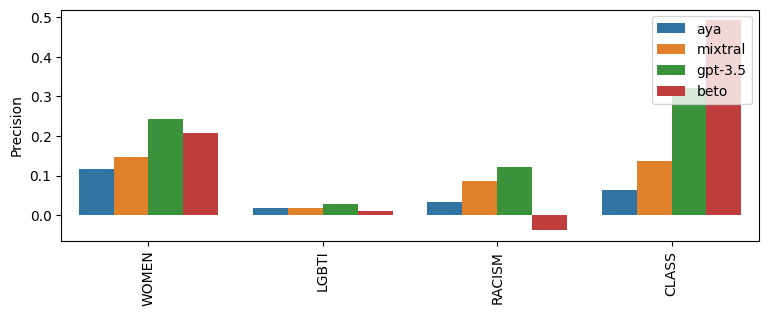

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot



def plot_metric(df, metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df[(df["metric"] == metric) & (df["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order, order=labels)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(diff, metric, labels)
plt.savefig(f"img/{metric}_regional.png", bbox_inches='tight', dpi=300)

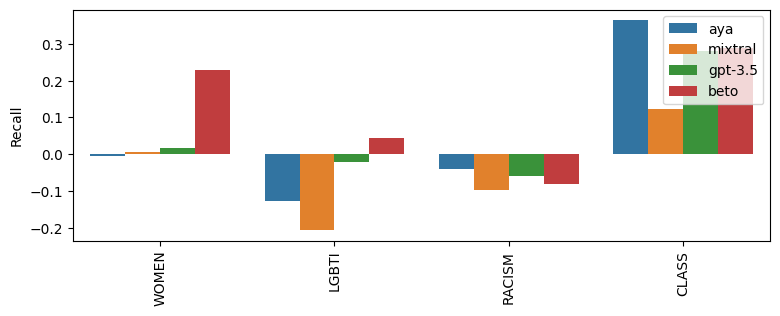

In [20]:

metric = "recall"
plot_metric(diff, metric, labels)
plt.savefig(f"img/{metric}_regional.png", bbox_inches='tight', dpi=300)

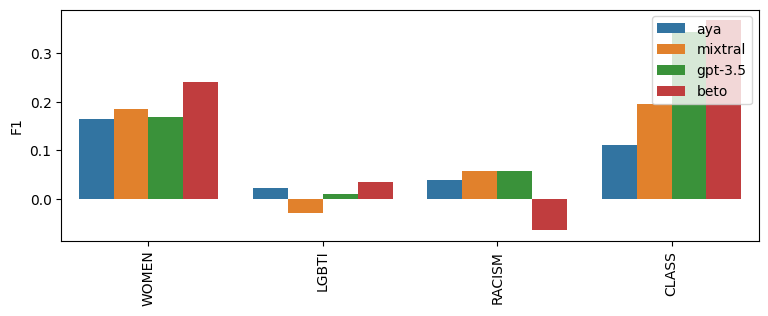

In [21]:
metric = "f1"
plot_metric(diff, "f1", labels)
plt.savefig(f"img/{metric}_regional.png", bbox_inches='tight', dpi=300)

GPT mejora bastante su precisión en el caso de tweets con contenido regional, veamos a qué se debe observando los resultados.

In [22]:
label = "HATEFUL"
pred_label = f"PRED_{label}"

columns_to_show = ["context_tweet", "text", "pred_cot" ] + labels + pred_labels

gold = dfs_regional["beto"][label].astype(bool)

pred_beto = dfs_regional["beto"][pred_label].astype(bool)
pred_gpt = dfs_regional["gpt-3.5"][pred_label].astype(bool)

tp_beto = (gold & pred_beto)
tn_beto = (~gold & ~pred_beto)
fp_beto = (~gold & pred_beto)
fn_beto = (gold & ~pred_beto)

print(f"Pred BETO en Class")
print(f"TP: {tp_beto.sum()}")
print(f"TN: {tn_beto.sum()}")
print(f"FP: {fp_beto.sum()}")
print(f"FN: {fn_beto.sum()}")


Pred BETO en Class
TP: 124
TN: 1294
FP: 41
FN: 88


In [23]:

tp_gpt = (gold & pred_gpt)
tn_gpt = (~gold & ~pred_gpt)
fp_gpt = (~gold & pred_gpt)
fn_gpt = (gold & ~pred_gpt)

print(f"Pred GPT en Class")
print(f"TP: {tp_gpt.sum()}")
print(f"TN: {tn_gpt.sum()}")
print(f"FP: {fp_gpt.sum()}")
print(f"FN: {fn_gpt.sum()}")


Pred GPT en Class
TP: 129
TN: 1203
FP: 132
FN: 83


In [24]:
beto_pred_labels = [f"PRED_{label}_beto" for label in labels]
columns_to_show_here = ["context_tweet", "text"] + labels + ["pred_cot"] + [p+"_beto" for p in pred_labels]


dfs_regional["gpt-3.5"].join(dfs_regional["beto"][pred_labels], rsuffix="_beto").loc[tn_gpt & fp_beto, columns_to_show_here]

,context_tweet,text,WOMEN,LGBTI,RACISM,CLASS,pred_cot,PRED_WOMEN_beto,PRED_LGBTI_beto,PRED_RACISM_beto,PRED_CLASS_beto
id,,,,,,,,,,,
334663,Luis Novaresio se comprometió con Braulio Bauab: “Estamos felices” https://t.co/9TxObocon2,@usuario Pero qué me importa lo que haga este nabo con su culo?,0,0,0,0,"El tweet contiene un insulto hacia Luis Novaresio (""nabo"") pero no hace referencia a ninguna característica protegida. La respuesta es ""nada"".",0,1,0,0
355204,"Ofelia Fernández apoyó al Gobierno en la polémica por los presos y apuntó a la Justicia que ""odia a las mujeres"" https://t.co/BD3jgGCOWI",@usuario Está gorda cara de gaver que devuelva lo que viene robando desde enero,0,0,0,0,"El texto contiene insultos hacia la persona mencionada, Ofelia Fernández, calificándola como ""gorda"" y utilizando un término despectivo (""cara de gaver""). A pesar de que es un comentario que denigra a la persona, no incluye discursos de odio basados en características protegidas. Por lo tanto, la respuesta final es ""nada"".",1,0,0,0
392265,"Coronavirus: Alberto Fernández advirtió que, 'si el relajamiento sigue, las fuerzas de seguridad saldrán a la calle para disipar a la gente' https://t.co/Ejo6OSzvmW",@usuario Que hipócrita hijo de 1000 putas. Desaloja a los mapuches de mascardi la concha de tu madre,0,0,0,0,"El texto utiliza un insulto hacia Alberto Fernández (""hijo de 1000 putas"") y lo critica por su accionar con los mapuches en Mascardi. La expresión ""concha de tu madre"" es un insulto vulgar, pero no está dirigido hacia una característica protegida. La respuesta final es ""nada"".",0,0,1,0
368052,"Martha Rosenberg: “En situación de pandemia, legalizar el aborto es más urgente que nunca” | Por Mariana Fernández Camacho https://t.co/drwsysry27",@usuario Vieja chota,0,0,0,0,"El texto contiene un insulto hacia Martha Rosenberg (vieja), pero no menciona nada relacionado con las características protegidas. La respuesta final es ""nada"".",1,0,0,0
346078,El Presidente postergó el envío de la ley de aborto al Congreso por la pandemia de coronavirus https://t.co/PwG52mmUlP,@usuario Feministas defensores de chorros,0,0,0,0,"El texto insulta a las feministas (""Feministas defensores de chorros"") pero no hace referencia a ninguna característica protegida en sí. A pesar de la negatividad de la expresión, no se puede clasificar como discurso de odio hacia un grupo protegido. La respuesta final es ""nada"".",1,0,0,0
368970,"Romina Manguel apuntó contra Susana Giménez: ""Mucha gente la quiere y a mí me incomoda"" https://t.co/kyczDYLGfZ","@usuario A SG hay que meterle una estampilla For Export en el culo y que no vuelva más....Ignorante,bruta y tilinga.",0,0,0,0,"El texto contiene insultos hacia Susana Giménez y la califica de ignorante, bruta y tilinga. A pesar de no mencionar directamente ninguna característica protegida, el tono hostil e irrespetuoso del mensaje hacia una figura pública como Susana Giménez podría considerarse despectivo. Por lo tanto, la respuesta final podría ser ""nada"".",1,0,0,0
397537,Así luce el actor Elliot Page tras declararse trans https://t.co/yeTGhw6ooT,@usuario Tirando facha.,0,0,0,0,"El texto simplemente elogia la apariencia de Elliot Page sin caer en discursos de odio ni comentarios discriminatorios. Por lo tanto, la respuesta es ""nada"".",0,1,0,0
405652,Así quedó la iglesia de El Bolsón vandalizada por mapuches https://t.co/HX65fLHMmO,"@usuario Esos no son mapuches,son hdp delincuentes",0,0,0,0,"El texto no contiene discurso de odio hacia los pueblos aborígenes (mapuches), ya que si bien los califica como delincuentes, no hay una expresión de rechazo intenso e irracional hacia ellos por ser parte de un grupo étnico en particular. La respuesta final es ""nada"".",0,0,1,0
339470,El PJ elogió la actitud de China frente a la pandemia del coronavirus https://t.co/IYGVlArQuJ,@usuario Que elogian? Lo que ocasionó matando a todo el mundo x un experimento que falló. \nEso es un elogio? \nO se piensan que uno es tan id

A ver qué agarra ChatGPT que BETO no...

In [25]:
beto_pred_labels = [f"PRED_{label}_beto" for label in labels]
columns_to_show_here = ["context_tweet", "text"] + labels + ["pred_cot"] + score_labels


dfs_regional["gpt-3.5"].join(dfs_regional["beto"][score_labels], rsuffix="_beto").loc[tp_gpt & fn_beto, columns_to_show_here].round(3)

,context_tweet,text,WOMEN,LGBTI,RACISM,CLASS,pred_cot,SCORE_WOMEN,SCORE_LGBTI,SCORE_RACISM,SCORE_CLASS
id,,,,,,,,,,,
398914,Mara Gómez: la historia de la primera futbolista trans en el torneo argentino https://t.co/rBx3pMPUbB https://t.co/l5I1j0xFku,"@usuario Ponga huevos, Mara ponga huevos...",0,1,0,0,"El texto alienta a Mara Gómez como futbolista, pero utiliza la expresión ""ponga huevos"" de manera discriminatoria, con el objetivo de cuestionar su masculinidad y su identidad de género como mujer trans. La respuesta final es ""lgbti"".",0.003,0.384,0.002,0.001
404354,Británica llegó a Perú por 10 días y se quedó por amor: vive sin agua potable y entre insectos #AMiNoMeImportaElDinero #TengoLoQueYoMásQuieroAMiLado #ElAmorLeGanaATodo? #ConocéLaHistoria!!! https://t.co/1AvKrD7OJb,@usuario La gaver del peruano. Mamá.,1,0,0,0,"El texto contiene un comentario despectivo hacia los peruanos, utilizando un término vulgar y discriminatorio. La respuesta final es ""racismo"".",0.007,0.214,0.006,0.000
398722,"Hebe de Bonafini criticó a los supermercados y llamó a “suplantar la carne por arroz, garbanzos y lentejas” https://t.co/s77NGCdmAA","@usuario Vieja chupa pi., a vos te gusta la morcilla.",1,0,0,0,"El texto contiene un insulto hacia Hebe de Bonafini, llamándola ""vieja chupa pi."" pero además hace referencia de forma despectiva a su alimentación, utilizando un comentario sexista y vulgar. La respuesta final es ""mujer"".",0.020,0.011,0.009,0.005
341372,Coronavirus: Florencia Kirchner compartió una curiosa reflexión sobre la cuarentena https://t.co/0nI5GKR1NL https://t.co/8KSATPqhFK,@usuario Devolve la plata bicho canasto! Que si mamita no fuera quien es estarías pagando badoo premium a ver si algún ciego te toca y laburando vendiendo productos a domicilio,1,0,0,0,"El texto hace referencia a Florencia Kirchner de manera insultante por su aspecto físico (""bicho canasto"") y la acusa de recibir dinero ilegítimamente (""devolvé la plata""). Además, hace alusión a su madre (""si mamita no fuera quien es""), lo cual puede considerarse despectivo. En este caso, se muestra un discurso de odio hacia una mujer y hacia la familia de la misma, aunque de manera indirecta. Por lo tanto, la respuesta final es ""mujer"".",0.494,0.001,0.014,0.007
329906,Toma de tierras en Guernica: los ocupantes hicieron un festival en protesta anticipada por el desalojo que ordenó la justicia https://t.co/ZpDNtXFIEr,"@usuario Es increíble este país, los delincuentes haciendo festival p/bancar un delito q se encuentra en el código penal. \nTodo esto es producto exclusivo de la izquierda socialista y el kirchnerismo, vivimos en un país zurdoprogre de la mas baja calaña.",0,0,0,1,"El texto contiene un discurso de odio que recae en la categoría de clase, al referirse de manera despectiva a quienes ocupan tierras como delincuentes y vincularlos exclusivamente con la izquierda socialista y el kirchnerismo. También los califica como ""zurdoprogre"", un término peyorativo utilizado para desacreditar a aquellos con ideologías progresistas de izquierda. La respuesta final es ""clase"".",0.002,0.005,0.004,0.029
388149,[OPINIÓN] En 2018 se registró la tasa más baja de natalidad de las últimas décadas y el tema no parece importarles a nuestros dirigentes | Por Claudia Peiró https://t.co/yghRN7LuI8,@usuario @usuario La mayoría nacimientos de madres luchonas parásitos engendrados del kirchnerimo.,1,0,0,1,"El texto utiliza términos despectivos como ""luchonas"" y ""parásitos engendrados del kirchnerismo"" para referirse a las madres y niños nacidos en ese período. Esto implica un rechazo y desprecio a un grupo de personas por su ideología política, por lo que la respuesta final es ""clase"".",0.014,0.001,0.002,0.317
402614,Keira Knightley no volverá a filmar escenas de sexo dirigidas por hombres https://t.co/7Lz9Wbjhds,"@usuario y cuantas hizo...? ademas ni tetas tiene, parece un pibe.",1,0,0,0,"El texto menciona el aspecto físico de Keira Knightley y cuestiona su feminidad al c

In [26]:
dfs_regional["gpt-3.5"][columns_to_show].join(dfs_regional["beto"][pred_labels], rsuffix="_beto").loc[fp_gpt & tn_beto, columns_to_show].sample(10)

,context_tweet,text,pred_cot,WOMEN,LGBTI,RACISM,CLASS,PRED_WOMEN,PRED_LGBTI,PRED_RACISM,PRED_CLASS
id,,,,,,,,,,,
348519,Científicos identificaron en China otro virus respiratorio“con potencial para convertirse en pandemia” https://t.co/TQYuvSXqrT,@usuario Que se queden tranca en su país y no jodan dale !!!,"El texto muestra rechazo hacia los chinos, sugiriendo que no salgan de su país y no molesten a los demás. Esto implica que los chinos son vistos como una amenaza y se les pide que no interfieran. La respuesta final es ""racismo"".",0,0,0,0,0,0,1,0
376268,Potenciar Acompañamiento: lanzan un incentivo de $ 8.500 por mes para jóvenes en recuperación de adicciones https://t.co/JZmbzTsmFO,"@usuario ""Me recupere""-""toma $""- una semana despues cuando ya se morfaron el chamuyo pintan un par de bolsas del transa que ellos mismos ya conocen. Negocio redondo boloh. Querian que la guita circule? Ahi tene' 😅 y encima ni roban para comprar xq ya la tienen en el bolsillo","El texto hace referencia de manera despectiva a jóvenes en recuperación de adicciones, insinuando que van a malgastar el dinero en drogas. La expresión ""toma $"" y ""se morfaron el chamuyo"" son despectivas hacia estas personas con problemas de adicciones. Además, utiliza un lenguaje despectivo y estereotipado al hablar de ""un par de bolsas del transa"", en referencia a un dealer de drogas. Por otro lado, el término ""negocio redondo"" implica que estas personas van a aprovechar la situación para su beneficio. En este caso, el texto contiene discurso de odio hacia personas con adicciones, lo que cae en la categoría de ""clase"". La respuesta final es ""clase"".",0,0,0,0,0,0,0,1
404359,Británica llegó a Perú por 10 días y se quedó por amor: vive sin agua potable y entre insectos #AMiNoMeImportaElDinero #TengoLoQueYoMásQuieroAMiLado #ElAmorLeGanaATodo? #ConocéLaHistoria!!! https://t.co/1AvKrD7OJb,"@usuario Ella 33 y el 19, el pebete le da lindo no es boluda","El texto hace referencia a la diferencia de edades entre la pareja de manera despectiva y sexista, aludiendo a que el joven la encuentra atractiva por su juventud y por ende, implica que la mujer está con él por un interés físico. La respuesta final es ""mujer"".",0,0,0,0,1,0,0,0
379439,"La historia de una familia de cartoneros en la toma de Guernica: ""Por primera vez sentimos que tenemos un hogar"" https://t.co/Jt0TMKAXYz",@usuario Siempre del lado del delincuente!!!!!!!! Son unos delincuentes hdp!,"El texto utiliza el término ""delincuente"" de manera despectiva hacia las personas que viven en la toma de Guernica, insinuando que todos son delincuentes. Aunque no menciona explícitamente ninguna característica protegida, el término podría estar asociado a cuestiones de clase, ya que se refiere a personas de bajos recursos como delincuentes. Por lo tanto, la respuesta final es ""clase"".",0,0,0,0,0,0,0,1
382148,"Elizabeth Gómez Alcorta: “Por la pandemia, vamos a tener una suba de los femicidios y travesticidios” | Por Luciana Peker https://t.co/OGEL4INojA",@usuario @usuario El dia que llegue el boludicidio seremos felices.,"El texto hace una alusión despectiva a la violencia de género al referirse de manera irónica al ""boludicidio"", en clara minimización de los femicidios. Aunque no hace referencia directa a mujeres o al movimiento feminista, su contenido está relacionado con la violencia de género. La respuesta final es ""mujer"".",0,0,0,0,1,0,0,0
328864,"El desesperado pedido de Actrices Argentinas ante la violencia de género en cuarentena: ""Es urgente"" https://t.co/ARA0WcCFw3",@usuario Todo lo usan para victimizarse...me tienen podrida vayan a laburar parásitos,"El texto contiene un tono despectivo hacia las mujeres que denuncian violencia de género, calificándolas de ""victimizarse"" y llamándolas ""parásitos"". Aunque no hace referencia directa a la característica de género, su contenido denigra a las mujeres que sufren violencia. La respuesta final es ""mujer"".",0,0,0,0,1,0,0,0
359601,Polémica en las 

In [27]:
df_beto = dfs["beto"]

df_beto["HATEFUL"].mean()

0.08447971781305115